ARIMA EVO

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import funcs_for_proc
from transformator import (
    relative_concentration, get_accepted_maximum_value,
    get_all_relative_concentration)
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from itertools import product
from tqdm import tqdm

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
data = funcs_for_proc.get_data_from_csv('final_data/data_train/data_train', 'csv','final_data/train.csv')


In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
for file in data[:10]:
    fig, ax = plt.subplots(4, 1, figsize=(21, 21))
    fig.suptitle(file[0], fontsize=16)
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        datetime_pred= pd.date_range("2020-01-01", periods=pred, freq='12H')
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        maximum_level = get_accepted_maximum_value(gas, 0, '220kW')[1]
        max_axhspan_level = max(data_normal[gas].max(),maximum_level)*1.05

        max_text_level = (max_axhspan_level - maximum_level) / 2 + maximum_level
        accepted_text_level = (maximum_level - accepted_level) / 2 + accepted_level
        normal_text_level = accepted_level / 2
        text_egle = round(len(data_normal.index) * 0.90) 
        # Графики
        ax[i].vlines(datetime_pred[-1], 0, max_axhspan_level,
          color = 'r',
          linewidth = 2,
          linestyle = '--')
        ax[i].plot(data_normal.index, data_normal[gas], label=pred, color='green') 
        # Зоны
        ax[i].axhspan(0, accepted_level, facecolor='1', color='green', alpha=0.3)
        ax[i].axhspan(accepted_level, maximum_level, facecolor='1', color='yellow', alpha=0.3)
        ax[i].axhspan(maximum_level, max_axhspan_level, facecolor='1', color='red', alpha=0.3)
#         Текст
        ax[i].text(data_normal.index[text_egle], max_text_level, "Предотказное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], accepted_text_level, "Развитие дефекта", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], normal_text_level, "Нормальное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].set_xlabel("Время", fontsize=12)
        ax[i].set_ylabel(f'Концентрация {gas}', fontsize=12)
        ax[i].legend()

    plt.show()

In [ ]:
for file in data[:1]:
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        print("Dickey-Fuller test %s" %gas,sm.tsa.stattools.adfuller(data_normal[gas]))
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()


In [ ]:
for file in data[:1]:
    data_normal=file[2].diff(periods=1).dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



In [ ]:
for file in data[:1]:
    data_normal=file[2].diff().dropna().diff().dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



In [ ]:
file=data[30]
data_normal=file[2]
mindfGas=pd.DataFrame()
model_res={}
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    df=pd.DataFrame(columns=['aic','param','param_seasonal'])
    p  = q = range(0, 2)
    d=[2]
    pdq = list(product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]
    warnings.filterwarnings("ignore") 
    aics=[]
    params=[]
    param_seasonals=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                                order=param,
                                                
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                aics.append(results.aic)
                params.append(param)
                param_seasonals.append(param_seasonal)
            except BaseException as e :
                continue
    df=pd.DataFrame({'aic':aics,'param':params,'param_seasonal':param_seasonals})
    minaic_param=df[df.aic == df.aic.min()].iloc[[0]]
    print(minaic_param)
    print(minaic_param.param.values,minaic_param.param_seasonal.values)
    mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                order=minaic_param.param.values[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    model_res[gas] = mod.fit()

    print(model_res[gas].summary().tables[1])

In [ ]:
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    model_res[gas].plot_diagnostics(figsize=(18, 8))
    model_forecast=model_res[gas]
    plt.show()

In [ ]:
for file in data[:10]:
    models=funcs_for_proc.find_best_arima_model_for_gas(file)
    funcs_for_proc.plot_predict(file,models)
    plt.show()

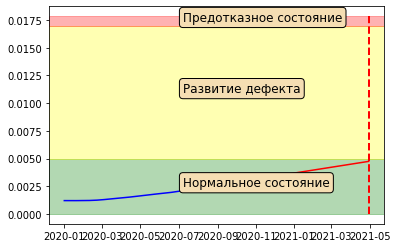

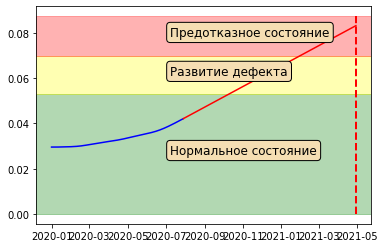

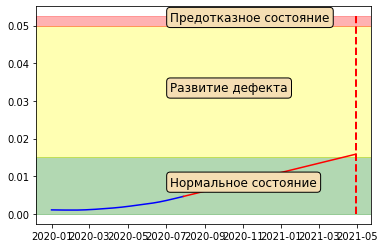

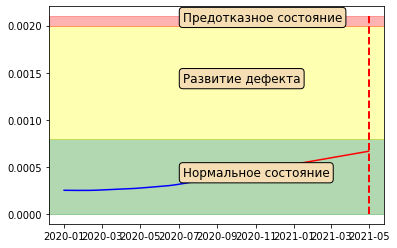

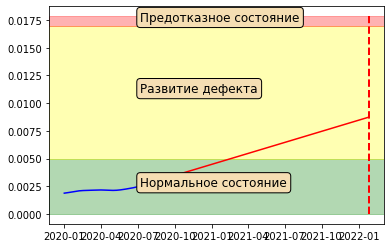

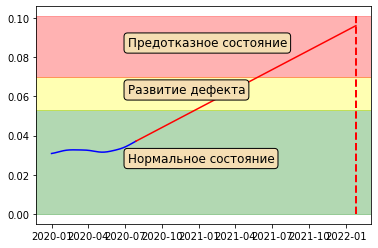

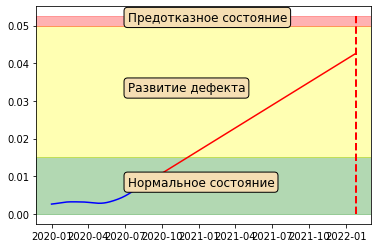

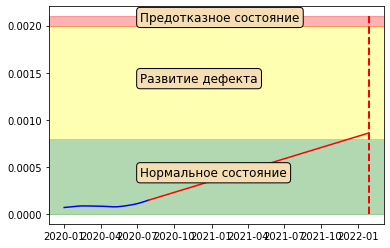

In [6]:
import funcs_for_proc
for file in data[:2]:
    models=funcs_for_proc.auto_arima(file)
    funcs_for_proc.plot_predict_auto_arima(file,models)

In [15]:
import funcs_for_proc
from sklearn.metrics import mean_absolute_error
import pmdarima as pm
def predict_time_st(models, file):
    time_gas_ar = []
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        # n=1
        # while models[gas].predict(n_periods=n)[-1]<accepted_level and n<1500:
        #     n+=1
        pered_val = models[gas].predict(n_periods=1500)
        time_gas = np.argwhere(pered_val < accepted_level).max()
#         if time_gas.size==0:
#             stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
#                                          start_P=0, seasonal=False, trace=False,
#                                          error_action='ignore',
#                                          suppress_warnings=True,
#                                          stepwise=True, n_jobs=8)
#             pered_val = stepwise_fit.predict(n_periods=1500)
#             time_gas = np.argwhere(pered_val > accepted_level)
#             if time_gas.size==0:
#                 stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=1,
#                                          start_P=0, seasonal=False, trace=False,
#                                          error_action='ignore',
#                                          suppress_warnings=True,
#                                          stepwise=True, n_jobs=8)
#                 pered_val = stepwise_fit.predict(n_periods=1500)
#                 time_gas = np.argwhere(pered_val > accepted_level)
#                 if time_gas.size==0:
#                     return 500
#             else:
#                 time_gas=time_gas.min()
#         else:
#             time_gas=time_gas.min()
        time_gas_ar.append(time_gas)
    return np.min(time_gas_ar)+len(file[2][gas])
df=pd.DataFrame(columns=['fimename','true','pred'])
data_for_an=data[:20]
pbar = tqdm(total=len(data_for_an))
for i,file in enumerate(data_for_an):
    models=funcs_for_proc.auto_arima(file)
    df.loc[i]=[file[0],file[1],predict_time_st(models,file)]
    pbar.update(1)
pbar.close()



 20%|██        | 4/20 [00:21<01:29,  5.59s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 25%|██▌       | 5/20 [00:26<01:21,  5.43s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 25%|██▌       | 5/20 [06:20<19:01, 76.07s/it]

 40%|████      | 8/20 [00:43<01:10,  5.85s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transfo

In [16]:
df.head(20)

,fimename,true,pred
0,2_trans_497.csv,550,564
1,2_trans_483.csv,1093,675
2,2_trans_2396.csv,861,603
3,2_trans_1847.csv,1093,756
4,2_trans_2382.csv,488,480
5,2_trans_2369.csv,734,1207
6,2_trans_454.csv,658,583
7,2_trans_1660.csv,533,516
8,2_trans_332.csv,713,704
9,2_trans_326.csv,496,488


In [17]:
print(mean_absolute_error(df.true,df.pred))

132.6


In [20]:
data_evo = funcs_for_proc.get_data_from_csv('final_data/data_test/data_test', 'csv',False)

In [21]:
def predict_time_st(models, file):
    time_gas_ar = []
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        # n=1
        # while models[gas].predict(n_periods=n)[-1]<accepted_level and n<1500:
        #     n+=1
        pered_val = models[gas].predict(n_periods=1500)
        time_gas = np.argwhere(pered_val < accepted_level).max()
#         if time_gas.size==0:
#             stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
#                                          start_P=0, seasonal=False, trace=False,
#                                          error_action='ignore',
#                                          suppress_warnings=True,
#                                          stepwise=True, n_jobs=8)
#             pered_val = stepwise_fit.predict(n_periods=1500)
#             time_gas = np.argwhere(pered_val > accepted_level)
#             if time_gas.size==0:
#                 stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
#                                          start_P=0, seasonal=False, trace=False,
#                                          error_action='ignore',
#                                          suppress_warnings=True,
#                                          stepwise=True, n_jobs=8)
#                 pered_val = stepwise_fit.predict(n_periods=1500)
#                 time_gas = np.argwhere(pered_val > accepted_level)
#                 if time_gas.size==0:
#                     return 500
#             else:
#                 time_gas=time_gas.min()
#         else:
#             time_gas=time_gas.min()
        time_gas_ar.append(time_gas)
    return np.min(time_gas_ar)+len(file[2][gas])
df=pd.DataFrame(columns=['id','predicted'])
data_for_an=data_evo
pbar = tqdm(total=len(data_for_an))
for i,file in enumerate(data_for_an):
    models=funcs_for_proc.auto_arima(file)
    try:
        df.loc[i]=[file[0],predict_time_st(models,file)]
    except:
         df.loc[i]=[file[0],500]
    pbar.update(1)
pbar.close()



  0%|          | 3/900 [00:38<3:13:37, 12.95s/it]

  0%|          | 2/900 [00:07<55:05,  3.68s/it]  d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

  1%|          | 8/900 [00:32<1:01:37,  4.14s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

  1%|          | 10/900 [00:43<1:14:31,  5.02s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

  1%|▏         | 13/900 [00:56<1:06:54,  4.53s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  ret


  7%|▋         | 66/900 [04:38<52:42,  3.79s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

  7%|▋         | 67/900 [04:42<55:17,  3.98s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

  8%|▊         | 68/900 [04:45<50:24,  3.64s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\ts


 20%|█▉        | 178/900 [12:01<48:28,  4.03s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 20%|██        | 180/900 [12:08<46:13,  3.85s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 20%|██        | 183/900 [12:19<45:36,  3.82s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 21%|██        | 185/900 [12:27<47:47,  4.01s/it]d:\proje

d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 26%|██▌       | 235/900 [15:42<42:37,  3.85s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 26%|██▋       | 237/900 [15:49<43:45,  3.96s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 27%|██▋       | 239/900 [15:57<44:12,  4.01s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels

d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 32%|███▏      | 290/900 [19:22<40:44,  4.01s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 34%|███▍      | 308/900 [20:37<41:13,  4.18s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 34%|███▍      | 309/900 [20:40<38:17,  3.89s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels


 41%|████      | 368/900 [24:47<34:42,  3.91s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 41%|████      | 369/900 [24:51<33:44,  3.81s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 41%|████      | 371/900 [24:59<33:38,  3.82s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 42%|████▏     | 379/900 [25:28<33:14,  3.83s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\proje


 50%|████▉     | 447/900 [30:01<29:21,  3.89s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 50%|████▉     | 449/900 [30:10<31:25,  4.18s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 50%|█████     | 452/900 [30:23<32:36,  4.37s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 50%|█████     | 453/900 [30:27<31:08,  4.18s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 51%|██


 56%|█████▋    | 508/900 [34:11<27:44,  4.25s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 57%|█████▋    | 509/900 [34:14<26:59,  4.14s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 57%|█████▋    | 511/900 [34:21<24:05,  3.72s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels


 63%|██████▎   | 569/900 [38:15<21:54,  3.97s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 63%|██████▎   | 571/900 [38:24<22:28,  4.10s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 64%|██████▎   | 572/900 [38:27<20:50,  3.81s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels

 76%|███████▌  | 684/900 [45:50<13:49,  3.84s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 76%|███████▌  | 686/900 [45:57<13:49,  3.88s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 77%|███████▋  | 690/900 [46:14<14:29,  4.14s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 77%|███████▋  | 695/900 [46:36<16:16,  4.76s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 77%|███


 84%|████████▍ | 754/900 [50:35<10:10,  4.18s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 84%|████████▍ | 755/900 [50:39<09:50,  4.07s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: d


 89%|████████▉ | 804/900 [53:51<05:57,  3.73s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 89%|████████▉ | 805/900 [53:55<05:57,  3.76s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 90%|████████▉ | 807/900 [54:02<05:41,  3.68s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels

In [22]:
df.to_csv('reg_arima_v2.csv',header=['id','predicted'],index=False)

In [148]:
import os
import glob
import pandas as pd
import numpy as np
import funcs_for_proc
from transformator import (
    relative_concentration, get_accepted_maximum_value,
    get_all_relative_concentration)
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from itertools import product
from tqdm import tqdm
import tsfel

In [149]:
data = funcs_for_proc.get_data_from_csv('final_data/data_train/data_train', 'csv','final_data/train.csv')
col=['H2', 'CO', 'C2H4', 'C2H2','H2v', 'COv', 'C2H4v', 'C2H2v','H2a', 'COa', 'C2H4a', 'C2H2a']

In [150]:
data_with_egde_val=pd.DataFrame(columns=col+['status'])

data_for_an=data
cfg = tsfel.get_features_by_domain()
pbar = tqdm(total=len(data_for_an))
for i,file in enumerate(data_for_an):
    insertdata=[]
    datav=file[2].diff()
    ex_f_df = tsfel.time_series_features_extractor(cfg, file[2],verbose=0)
    if i==0:
        data_with_egde_val_ef=pd.DataFrame(columns=ex_f_df.columns)
    data_with_egde_val_ef=data_with_egde_val_ef.append(ex_f_df,ignore_index=True)
    dataa=datav.diff()
    vmax_last=list(datav.iloc[len(datav)-1].values)
    amax_last=list(dataa.iloc[len(dataa)-1].values)
    con=list(file[2].iloc[len(file[2])-1].values)
    status=[file[1]]
    insertdata=con+vmax_last+amax_last+status
    data_with_egde_val.loc[i]=insertdata
    pbar.update(1)
pbar.close()
data_with_egde_val=pd.concat([data_with_egde_val, data_with_egde_val_ef], axis=1)

100%|██████████| 2100/2100 [03:12<00:00, 10.91it/s]


In [160]:
data_with_egde_val.status

0        550.0
1       1093.0
2        861.0
3       1093.0
4        488.0
         ...  
2095    1093.0
2096     805.0
2097     476.0
2098     550.0
2099    1093.0
Name: status, Length: 2100, dtype: float64

In [151]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

mean_absolute_error_f = make_scorer(mean_absolute_error)

In [152]:
data_full = data_with_egde_val.copy()
X_data = data_full.drop('status', axis=1)
y = data_full.status

In [158]:
data_full.head()

,H2,CO,C2H4,C2H2,H2v,COv,C2H4v,C2H2v,H2a,COa,...,3_Wavelet variance_0,3_Wavelet variance_1,3_Wavelet variance_2,3_Wavelet variance_3,3_Wavelet variance_4,3_Wavelet variance_5,3_Wavelet variance_6,3_Wavelet variance_7,3_Wavelet variance_8,3_Zero crossing rate
0,0.002294,0.042099,0.004630,0.000345,0.000004,0.000075,0.000020,5.818826e-07,-2.304700e-09,1.774780e-07,...,1.638706e-10,5.893392e-10,1.291968e-09,2.264273e-09,3.499456e-09,4.990925e-09,6.732171e-09,8.716697e-09,1.093794e-08,0.0
1,0.002764,0.037128,0.006520,0.000146,0.000005,0.000054,0.000033,6.528160e-07,-4.561590e-08,-4.215120e-07,...,2.339277e-11,8.472077e-11,1.870050e-10,3.300260e-10,5.136521e-10,7.377403e-10,1.002095e-09,1.306444e-09,1.650421e-09,0.0
2,0.001816,0.036885,0.002999,0.000253,0.000006,0.000087,0.000022,1.189219e-06,-1.104300e-08,-3.439780e-07,...,6.100834e-11,2.220033e-10,4.922065e-10,8.724728e-10,1.363959e-09,1.967899e-09,2.685527e-09,3.518034e-09,4.466538e-09,0.0
3,0.001659,0.028044,0.008604,0.000310,0.000006,0.000062,0.000019,1.690292e-07,-3.560000e-09,-4.741500e-08,...,1.539308e-10,5.523105e-10,1.207931e-09,2.111605e-09,3.254478e-09,4.627566e-09,6.221650e-09,8.027252e-09,1.003461e-08,0.0
4,0.002091,0.014124,0.013251,0.000347,0.000005,0.000044,0.000029,8.600990e-07,5.168470e-08,2.986550e-07,...,1.592310e-10,5.733399e-10,1.258149e-09,2.206824e-09,3.412843e-09,4.869495e-09,6.569796e-09,8.506477e-09,1.067203e-08,0.0


In [154]:
seed = 7
test_size = 0.3
X_trian, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=seed)

In [ ]:
param_test = {
 'max_depth':[3,4,5],
 'min_child_weight':[3,4,5],
}
gsearch = GridSearchCV(estimator = xgb.XGBRegressor(), 
 param_grid = param_test, scoring=mean_absolute_error_f,n_jobs=8, cv=5,verbose=8)

model = gsearch.fit(X_trian, y_train)
pred = model.predict(X_test)
print("Accuracy for model: %.2f" % (mean_absolute_error(y_test, pred)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
gsearch.best_params_

In [173]:
data_evo = funcs_for_proc.get_data_from_csv('final_data/data_test/data_test', 'csv',False)

In [174]:
data_with_egde_val_evo=pd.DataFrame(columns=['filename']+col)
data_for_an_evo=data_evo
cfg = tsfel.get_features_by_domain()

for i,file in enumerate(data_for_an_evo):
    insertdata=[]
    datav=file[2].diff()
    dataa=datav.diff()
    ex_f_df = tsfel.time_series_features_extractor(cfg, file[2],verbose=0)
    if i==0:
        data_with_egde_val_ef_evo=pd.DataFrame(columns=ex_f_df.columns)
    data_with_egde_val_ef_evo=data_with_egde_val_ef_evo.append(ex_f_df,ignore_index=True)
    vmax_last=list(datav.iloc[len(datav)-1].values)
    amax_last=list(dataa.iloc[len(dataa)-1].values)
    vmax_last=list(datav.iloc[len(datav)-1].values)
    con=list(file[2].iloc[len(file[2])-1].values)
    insertdata=[file[0]]+con+vmax_last+amax_last
    data_with_egde_val_evo.loc[i]=insertdata
data_with_egde_val_evo=pd.concat([data_with_egde_val_evo, data_with_egde_val_ef_evo], axis=1)

    

In [175]:
data_with_egde_val_evo.head()

,filename,H2,CO,C2H4,C2H2,H2v,COv,C2H4v,C2H2v,H2a,...,3_Wavelet variance_0,3_Wavelet variance_1,3_Wavelet variance_2,3_Wavelet variance_3,3_Wavelet variance_4,3_Wavelet variance_5,3_Wavelet variance_6,3_Wavelet variance_7,3_Wavelet variance_8,3_Zero crossing rate
0,2_trans_1.csv,0.003483,0.003719,0.006432,0.000196,0.000008,0.000019,0.000001,6.060696e-07,5.863900e-09,...,3.989423e-11,1.443547e-10,3.183293e-10,5.612348e-10,8.726864e-10,1.252363e-09,1.699961e-09,2.215149e-09,2.797536e-09,0.0
1,2_trans_10.csv,0.003478,0.025806,0.005931,0.000449,0.000008,0.000076,0.000017,9.335682e-07,-4.192380e-08,...,2.791356e-10,1.003805e-09,2.200971e-09,3.859060e-09,5.968466e-09,8.520768e-09,1.150853e-08,1.492514e-08,1.876463e-08,0.0
2,2_trans_1003.csv,0.002014,0.043260,0.006804,0.000079,0.000011,0.000091,0.000023,3.009226e-07,-5.400190e-08,...,6.873971e-12,2.484805e-11,5.480092e-11,9.673055e-11,1.507450e-10,2.170365e-10,2.958647e-10,3.875388e-10,4.923958e-10,0.0
3,2_trans_1004.csv,0.002637,0.008154,0.008418,0.000240,0.000008,0.000026,0.000005,8.657092e-07,1.909740e-08,...,7.197127e-11,2.599271e-10,5.720189e-10,1.006282e-09,1.561045e-09,2.234736e-09,3.025818e-09,3.932727e-09,4.953776e-09,0.0
4,2_trans_1005.csv,0.004024,0.020816,0.007958,0.000485,0.000012,0.000100,0.000029,8.293830e-07,-4.643520e-08,...,3.123334e-10,1.122796e-09,2.460992e-09,4.313226e-09,6.667762e-09,9.513890e-09,1.284167e-08,1.664180e-08,2.090540e-08,0.0


In [176]:
data_full_evo = data_with_egde_val_evo.copy()
X_data_test_evo = data_full_evo.drop('filename', axis=1)


In [177]:
pred_evo = model.predict(X_data_test_evo)

In [178]:
exportdata=pd.DataFrame([data_full_evo.filename,pred_evo.astype(int)]).T

In [179]:
exportdata.head()

,filename,Unnamed 0
0,2_trans_1.csv,846
1,2_trans_10.csv,646
2,2_trans_1003.csv,666
3,2_trans_1004.csv,982
4,2_trans_1005.csv,410


In [180]:
exportdata.to_csv('results_evo/reg_mod_v6.csv',header=['id','category'],index=False)